# Get preprocessed 'DontPatronizeMe' dataset

In [ ]:
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1-gNxTZfDL0aOpzOnxE80M29dUVjSoozn' -O 'train.csv'
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1-cSiEWP_NbDu7fo_7s8O5P163oKLQcBh' -O 'valid.csv'
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1-13l35-18IYPFSV_36llsJbb7c4Gu2o0' -O 'test.csv'
!pip install transformers


# Import package, model, dataset

In [6]:
import pandas as pd
import copy
from transformers import (
    DistilBertTokenizer, DistilBertForMaskedLM, DistilBertConfig,
    BertTokenizer, BertModel as Bert, BertConfig,
    activations
)
import torch
from torch.utils.data import DataLoader
from torch import nn, optim
import tqdm
import matplotlib.pyplot as plt

if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"
device = torch.device(dev)
print("using device: ", dev)

using device:  cpu


In [2]:
# read pandas data
train_path = './train.csv'
valid_path = './valid.csv'
test_path = './test.csv'

train_df = pd.read_csv(train_path).dropna()
valid_df = pd.read_csv(valid_path).dropna()
test_df = pd.read_csv(test_path).dropna()

In [ ]:
# download pretrained model and tokenizer
def save_model_tokenizer(tokenizer_class, model_class, name):
  tokenizer = tokenizer_class.from_pretrained(name)
  tokenizer.save_pretrained(f"./tokenizers/{name}-local")
  model = model_class.from_pretrained(name)
  model.save_pretrained(f"./models/{name}-local/")

save_model_tokenizer(DistilBertTokenizer, DistilBertForMaskedLM, "distilbert-base-uncased")
# save_model_tokenizer(BertTokenizer, Bert, "bert-base-cased")

# Hyperparameters

In [3]:
# hyperparameters
BATCH_SIZE = 16
MAX_LENGTH = 128 # max text length
LEARNING_RATE = 5e-5
EPOCH_NUM = 1
ROUNDING_WEIGHT = 0.3 # weight of rounding term, the probability of regenerated sequence 

# diffusion hyperparameter
BETA_MIN = 0.0001
BETA_MAX = 0.02
STEP_TOT = 2000 # total noise adding steps
COSIN_SCHEDULE = True # if alpha sequence is scheduled in cosin instead of linear patten
SAMPLE_SIZE = 3 # number of sample steps in each diffuse sequence
X_0_PREDICTION = True # if model predicts x_0 or x_{t-1}

# Model, trainer and loss function

In [12]:
class DistilBertModel(nn.Module):
  def __init__(self, embedding, projection, config=None) -> None:
    super().__init__()

    self.model = DistilBertForMaskedLM(config).to(device)
    
    self.embedding = copy.deepcopy(embedding.requires_grad_(False))
    self.projection = copy.deepcopy(projection.requires_grad_(False))
    self.projection.bias.data = torch.zeros(self.projection.bias.data.shape, device=device)
    self.model.set_input_embeddings(nn.Sequential())
    self.model.set_output_embeddings(nn.Sequential())

  def parameters(self):
    return self.model.parameters()
    # return list(model.model.parameters()) + list(model.embedding.parameters()) + list(model.projection.parameters())
  
  def forward(self, x, mask):
    '''
    return 
      feature_out, shape: [batch_size, seq_len, dim]
      vocab_out, shape: [batch_size, seq_len, vocab_size]
    '''
    
    x_out = self.model(x, mask)[0]
    return self.projection(x_out), x_out

class LinearModel(nn.Module):
  def __init__(self, embedding, projection, config=None) -> None:
    super().__init__()

    self.model = nn.Linear(768, 768).to(device)
    
    self.embedding = copy.deepcopy(embedding.requires_grad_(False))
    self.projection = copy.deepcopy(projection.requires_grad_(False))
    self.projection.bias.data = torch.zeros(self.projection.bias.data.shape, device=device)

  def parameters(self):
    return self.model.parameters()

  def forward(self, x, mask):
    hidden = self.model(x)
    return self.projection(hidden), hidden

class BertSmallModel(nn.Module):
  def __init__(self, config, train_embedding=False) -> None:
    super().__init__()

    # self.model = Bert.from_pretrained("./models/bert-base-cased-local/", local_files_only=True)
    self.model = Bert(config).to(device)

    self.embedding = copy.deepcopy(self.model.get_input_embeddings().requires_grad_(True))
    # self.projection = copy.deepcopy(self.model.get_input_embeddings().requires_grad_(False))
    # self.projection.bias.data = torch.zeros(self.projection.bias.data.shape, device=device)
    self.model.set_input_embeddings(nn.Sequential())
    # self.model.set_output_embeddings(nn.Sequential())

    # self.embedding = self.model.get_input_embeddings()
    # if not train_embedding:
    #   self.embedding.requires_grad_(False)
    # self.model.set_input_embeddings(nn.Sequential())

  def parameters(self):
    return list(model.model.parameters()) + list(model.embedding.parameters())

  def forward(self, x, mask):
    return self.model(x, mask)
    
# origin = DistilBertForMaskedLM.from_pretrained("./models/distilbert-base-uncased-local", local_files_only=True).to(device)
# configuration = DistilBertConfig()
# model = DistilBertModel(origin.get_input_embeddings(), origin.get_output_embeddings(), config=configuration)

# model = LinearModel(origin.get_input_embeddings(), origin.get_output_embeddings())

configuration = BertConfig()
model = BertModel(config=configuration)

# parameter only include model, no embedding layer
# trainer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
trainer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)


In [14]:
sum(p.numel() for p in model.parameters() if p.requires_grad), configuration


(109482240,
 BertConfig {
   "attention_probs_dropout_prob": 0.1,
   "classifier_dropout": null,
   "hidden_act": "gelu",
   "hidden_dropout_prob": 0.1,
   "hidden_size": 768,
   "initializer_range": 0.02,
   "intermediate_size": 3072,
   "layer_norm_eps": 1e-12,
   "max_position_embeddings": 512,
   "model_type": "bert",
   "num_attention_heads": 12,
   "num_hidden_layers": 12,
   "pad_token_id": 0,
   "position_embedding_type": "absolute",
   "transformers_version": "4.21.1",
   "type_vocab_size": 2,
   "use_cache": true,
   "vocab_size": 30522
 })

In [5]:
if COSIN_SCHEDULE:
  def scheduler(t):
    s = 0.008 # smalle value prevent beta_t too small, from Improved DDPM paper
    return torch.cos(torch.pi / 2 * (t/STEP_TOT + s) / (1 + s)) ** 2
  ts = torch.arange(STEP_TOT).to(device)
  alpha_cumprod = scheduler(ts) / scheduler(torch.zeros(1, device=device))

else:
  betas = torch.hstack([torch.zeros(1), torch.linspace(BETA_MIN, BETA_MAX, STEP_TOT)]).to(device)
  alphas = 1 - betas
  alpha_cumprod = torch.cumprod(alphas[:-1], 0)
def diffuse_t(x, t):
  '''
  input:
    x_shape: [batch_size, seq_len, dim]
    t shape: [sample num] 
      NOTE: not necessary have hyperparameter sample_size number of element, to allow single diffuse generation

  return shape [sample_num * batch_size, seq_len, dim]
  '''
  batch_size, seq_len, dim = x.shape
  sample_shape = (t.numel(), *(1, ) * len(x.shape))

  noise = torch.normal(0, 1, x.shape).to(device)
  mean = torch.sqrt(alpha_cumprod[t].reshape(sample_shape)) * x 
  epsilon = noise * torch.sqrt(1 - alpha_cumprod[t]).reshape(sample_shape)
  return (mean + epsilon).reshape((t.numel() * batch_size, seq_len, dim))

def generate_diffuse_pair(x_0, t, t_next=None):
  '''
  input:
    x_0 shape: [batch_size, seq_len, dim],
    t shape: [sample_num] 
      NOTE: not necessary have hyperparameter sample_size number of element, to allow single diffuse generation
  
  return (net input, net target)
    net input shape: [sample_num * batch_size, seq_len, dim]
    net target shape: if t_next is None then [batch_size, seq_len, dim] else [sample_num * batch_size, seq_len, dim]
  '''
  if X_0_PREDICTION:
    # predict x_0
    return (diffuse_t(x_0, t), x_0)

  # predict x_{t_next}
  return (diffuse_t(x_0, t), diffuse_t(x_0, t_next))

def loss(model, x_t, x_1, x_tgt, x_0, mask, idx, loss_func):
  ''' 
  input: 
    model,
    x_t, x_tgt shape: [sample_num * batch_size, seq_len, dim]
      NOTE: x_tgt only used when X_0_PREDICTION is False
    x_1, x_0 shape: [batch_size, seq_len, dim]
    mask shape: [batch_size, seq_len]
    idx shape: [batch_size, seq_len]
    loss_func

  return triple loss terms
  '''
  
  repeat_shape = (SAMPLE_SIZE, *(1, ) * (len(x_t.shape) - 1))

  # x_t restore loss
  x_t_prob, x_t_hidden = model(x_t, mask.repeat((SAMPLE_SIZE, 1)))
  if X_0_PREDICTION:
    x_t_loss = loss_func(x_t_hidden, x_0.repeat(repeat_shape))
  else:
    x_t_loss = loss_func(x_t_hidden, x_tgt)

  # x_1 restore loss
  x_1_prob, x_1_hidden = model(x_1, mask)
  x_1_loss = loss_func(x_1_hidden, x_0)

  # output sequence probability loss, applied to both x_1 and x_t restore
  idx = idx.unsqueeze(dim=-1)
  x_t_prob_loss = -(nn.functional.softmax(x_t_prob, dim=-1)).gather(-1, idx.repeat(repeat_shape)).log().mean()
  x_1_prob_loss = -(nn.functional.softmax(x_1_prob, dim=-1)).gather(-1, idx).log().mean()
  
  return x_t_loss, x_1_loss, ROUNDING_WEIGHT * (x_t_prob_loss + x_1_prob_loss)


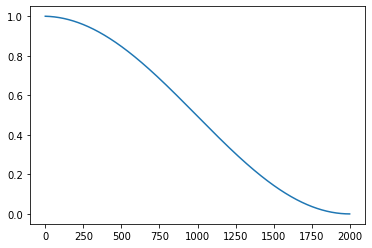

In [48]:
plt.plot(alpha_cumprod)
plt.show()

# Define dataset

In [6]:
# define dataset 
class DPMDataset(torch.utils.data.Dataset):
    def __init__(self, tokenizer, input_df):
        self.tokenizer = tokenizer
        self.texts = input_df['text'].tolist()

    def collate_fn(self, batch):
        # function for batch allocation
        texts = []

        for b in batch:
            texts.append(b)

        encodings = self.tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=MAX_LENGTH)

        return {"input_ids": encodings["input_ids"].to(device), "attention_mask": encodings["attention_mask"].to(device)}

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]

tokenizer = DistilBertTokenizer.from_pretrained("./tokenizers/distilbert-base-uncased-local/", local_files_only=True)
# tokenizer = BertTokenizer.from_pretrained("./tokenizers/bert-base-cased-local", local_files_only=True)

train_dataset = DPMDataset(tokenizer, train_df)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=train_dataset.collate_fn)


# Training

In [7]:
# training
# model = torch.load("model_continue1.pickle")["net"]
# trainer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
model.train()
print("start training")
for epoch in range(EPOCH_NUM):
  acc_loss = 0
  with tqdm.tqdm(train_loader, unit="batch") as tepoch: 
    for epoch, x in enumerate(tepoch):
  # for x in train_loader:
      x_0 = model.embedding(x["input_ids"])
      repeat_shape = (SAMPLE_SIZE, *(1, ) * (len(x_0.shape) - 1))
      t = torch.randint(0, STEP_TOT, repeat_shape, device=device)
      if X_0_PREDICTION:
        x_t = diffuse_t(x_0, t)
        x_tgt = None
      else:
        x_t, x_tgt = generate_diffuse_pair(x_0, t, torch.max(t - 30, torch.zeros(t.shape, device=device, dtype=torch.int64)))
      x_1 = diffuse_t(x_0, torch.ones(1, dtype=torch.int64, device=device))

      trainer.zero_grad()
      x_t_loss, x_1_loss, prob_loss = loss(model, x_t, x_1, x_tgt, x_0, x["attention_mask"], x["input_ids"], nn.L1Loss())
      l = x_t_loss + x_1_loss + prob_loss
      l.backward()
      trainer.step()

      acc_loss += l

      tepoch.set_description(f"Epoch {epoch}")
      tepoch.set_postfix(
                         x_t_hidden=x_t_loss.item(),
                         x_1_loss=x_1_loss.item(),
                         prob_loss=prob_loss.item(),
                         tot_loss=l.item())
      break

  print(f"epoch {epoch} average loss: {acc_loss / len(train_loader)}, last loss x_t_loss, x_1_loss, prob_loss: {x_t_loss.item(), x_1_loss.item(), prob_loss.item()}")
  break

start training


Epoch 0:   0%|          | 0/419 [01:15<?, ?batch/s, prob_loss=6.55, tot_loss=8.08, x_1_loss=0.76, x_t_hidden=0.763]

epoch 0 average loss: 0.019278086721897125, last loss x_t_loss, x_1_loss, prob_loss: (0.7628515958786011, 0.7602791786193848, 6.55438756942749)


In [21]:
mask = x["attention_mask"]
output = model(x_t, mask.repeat((SAMPLE_SIZE, 1, 1)))

In [22]:
mask.repeat((SAMPLE_SIZE, 1, 1)).shape

torch.Size([3, 16, 128])

# Evaluate

In [ ]:
# trial on inference
# model = torch.load("model_1.pickle")["net"].to(device)

model.eval()
origin_text = train_df.loc[11]["text"]
text = tokenizer(origin_text, return_tensors='pt', padding=True, truncation=True, max_length=MAX_LENGTH).to(device)
print("origin text: ", origin_text)

x_0 = model.embedding(text["input_ids"])
repeat_shape = (SAMPLE_SIZE, *(1, ) * (len(x_0.shape) - 1))
t = torch.randint(0, STEP_TOT, repeat_shape, device=device)

noised_text = diffuse_t(x_0, t)
# x_1 = diffuse_t(x_0, torch.ones(1, dtype=torch.int64, device=device).repeat(repeat_shape))
x_t = diffuse_t(x_0, torch.tensor([25], dtype=torch.int64, device=device).repeat(repeat_shape))
print("noise added")
print("t", t)
print("x_0 ground truth: ", tokenizer.decode((x_0 @ model.projection.weight.data.T).argmax(dim=-1)[0]))

# multi-step inference
restored = x_t
for i in range(5):
  out, restored = model(restored, text["attention_mask"].repeat(repeat_shape)) 

  # print("inferred: ", tokenizer.decode(torch.softmax(out, dim=-1).argmax(dim=-1)[0]))
  print("inferred: ", tokenizer.decode(out.argmax(dim=-1)[0]))
  # print("loss", loss(model, noised_text, x_1, x_0.repeat(repeat_shape), text["attention_mask"].repeat(repeat_shape), text["input_ids"], nn.L1Loss()))

print("text t effectiveness")
# effectiveness of model on large t
for i in range(5, 500, 25):
  x_t = diffuse_t(x_0, torch.tensor([i], dtype=torch.int64, device=device).repeat(repeat_shape))
  out, _ = model(x_t, text["attention_mask"].repeat(repeat_shape)) 

  # print("inferred: ", tokenizer.decode(torch.softmax(out, dim=-1).argmax(dim=-1)[0]))
  print("t: ", i, "restore: ", tokenizer.decode(out.argmax(dim=-1)[0]))




origin text:  B.C. housing minister Selina Robinson said that the project represents hope for many women and families in need .
noise added
t tensor([[[1465]],

        [[1200]]])
x_0 ground truth:  [CLS] b.rdon. housing minister selinaomba 690 that the project represents hope for many women and families in need. [SEP]
inferred:  [CLS] b. a. housing minister se " [SEP] said that ‖ project is hope for many women and families in need. [SEP]
inferred:  [CLS] in [SEP] in [SEP] high his in " [SEP] his that ‖ " is " for in [SEP] and [SEP] in models [SEP] [SEP]
inferred:  ##aint buena hapoelorf hapoel buenaviere buena buena hapoel hapoel buenaviere buena buenaviere buenaviere hapoel buena hapoel buenaaint hapoel hapoel
inferred:  ##viereviereviereviereviereviereviereviereviereviereviereviereviereviereviereviereviereviereviereviereviereviereviereviereviere
inferred:  ##viereviereviereviereviereviereviereviereviereviereviereviereviereviereviereviereviereviereviereviereviereviereviereviereviere


In [ ]:
# save model
torch.save({"net": model.to(torch.device("cpu"))}, "model.pickle")